# BASE MODELS

## SVM

Training Accuracy: 0.9610
Test Accuracy:     0.9037

Classification Report:

              precision    recall  f1-score   support

          -1       0.87      0.70      0.78       536
           0       0.91      0.96      0.93      1819
           1       0.90      0.91      0.91      1436

    accuracy                           0.90      3791
   macro avg       0.90      0.86      0.87      3791
weighted avg       0.90      0.90      0.90      3791



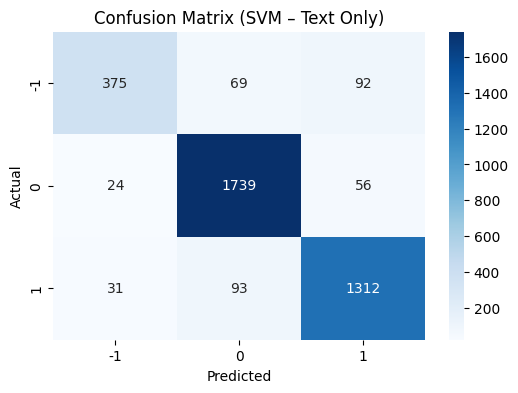


Saved predictions to: output_svm_text_only.csv


In [ ]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Load
file_path = "interstellar_posts_labelled.csv"
df = pd.read_csv(file_path)

# 2. Specify columns
TEXT_COL   = "TEXT"
SENT_SCORE = "sentiment"        # for CSV output only
LABEL_COL  = "sentiment_label"  # categorical: -1, 0, 1

# 3. Drop missing & preprocess
df.dropna(subset=[TEXT_COL, LABEL_COL], inplace=True)
def preprocess_text(t):
    t = t.lower()
    t = re.sub(r'\d+', '', t)
    t = t.translate(str.maketrans("", "", string.punctuation))
    return t.strip()
df[TEXT_COL] = df[TEXT_COL].astype(str).apply(preprocess_text)

# 4. Train/test split (30%)
X_train, X_test, y_train, y_test = train_test_split(
    df[TEXT_COL],
    df[LABEL_COL],
    test_size=0.3,
    random_state=42,
    stratify=df[LABEL_COL]
)
s_test = df.loc[X_test.index, SENT_SCORE] # Get sentiment scores corresponding to X_test

# 5. TF-IDF vectorization (text-only features)
vectorizer  = TfidfVectorizer(max_features=5000)
Xtr_tfidf   = vectorizer.fit_transform(X_train)
Xte_tfidf   = vectorizer.transform(X_test)

# 6. Train SVM on TF-IDF only
svm = SVC(kernel="linear", C=1.0)
svm.fit(Xtr_tfidf, y_train)

# 7. Compute accuracies
train_acc = svm.score(Xtr_tfidf, y_train)
test_acc  = svm.score(Xte_tfidf, y_test)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")

# 8. Predict & detailed evaluation
y_pred = svm.predict(Xte_tfidf)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, labels=[-1,0,1]))

cm = confusion_matrix(y_test, y_pred, labels=[-1,0,1])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SVM – Text Only)")
plt.show()

# 9. Save predictions (including raw sentiment for reference)
results = pd.DataFrame({
    TEXT_COL:        X_test.values,
    SENT_SCORE:      s_test.values,
    "actual_label":  y_test.values,
    "predicted_label": y_pred
})
out_path = "output_svm_text_only.csv"
results.to_csv(out_path, index=False)
print(f"\nSaved predictions to: {out_path}")


In [ ]:
df = pd.read_csv("output_svm.csv")
print(df.head(20))

                                                 TEXT  sentiment  \
0   nolan’s next the odyssey\n\nlooks like at leas...     0.8415   
1   this is my flippus cuppus harmonius featuring ...     0.7163   
2                       hybrid factions   update news     0.0000   
3   how can i force trade factions to build statio...    -0.7686   
4   interstellar blend™ jing force kidney restorat...     0.0000   
5   best way to report bugs\n\nis there any stream...     0.9452   
6                        my recent euclid discoveries     0.0000   
7   cargo volume setting\n\nhello im thinking abou...     0.7937   
8   i took a dying leaf off my houseplant and pain...     0.0000   
9   forgotten photoshop and a tiny bit of illustra...    -0.4767   
10  generator k visual bug  version \n\ngreetings ...     0.8850   
11  they arent beings    they are us anyone else g...     0.0000   
12                       my recent euclid discoveries     0.0000   
13  help needed in preping non nerdy friend for 

In [ ]:
import pickle

# Save the TF-IDF Vectorizer as a .pkl file
with open('svm_tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

# Save the trained XGBoost model as a .pkl file
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm, file)


## XGBOOST

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:06:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 0.9409
Test Accuracy:     0.8908

Classification Report:

              precision    recall  f1-score   support

          -1       0.96      0.65      0.78       536
           0       0.86      0.97      0.91      1819
           1       0.92      0.88      0.90      1436

    accuracy                           0.89      3791
   macro avg       0.91      0.83      0.86      3791
weighted avg       0.90      0.89      0.89      3791



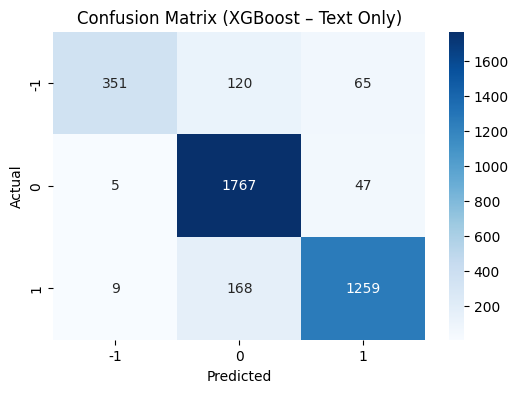


Saved predictions to: output_xgb_text_only.csv


In [ ]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

# 1. Load
file_path = "interstellar_posts_labelled.csv"
df = pd.read_csv(file_path)

# 2. Specify columns
TEXT_COL   = "TEXT"
SENT_SCORE = "sentiment"        # float between -1 and +1
LABEL_COL  = "sentiment_label"  # values are -1, 0, 1

# 3. Drop missing & preprocess text
df.dropna(subset=[TEXT_COL, LABEL_COL], inplace=True)

def preprocess_text(t):
    t = t.lower()
    t = re.sub(r'\d+', '', t)
    t = t.translate(str.maketrans("", "", string.punctuation))
    return t.strip()

df[TEXT_COL] = df[TEXT_COL].astype(str).apply(preprocess_text)

# 4. Remap labels to 0,1,2 for XGBoost
label_mapping = {-1: 0, 0: 1, 1: 2}
inv_mapping   = {v: k for k, v in label_mapping.items()}
df["label_enc"] = df[LABEL_COL].map(label_mapping)

# 5. Train/test split (30%)
X_train, X_test, y_train_enc, y_test_enc, s_train, s_test = train_test_split(
    df[TEXT_COL],
    df["label_enc"],
    df[SENT_SCORE],
    test_size=0.3,
    random_state=42,
    stratify=df["label_enc"]
)

# 6. TF-IDF vectorization (no sentiment feature)
vectorizer = TfidfVectorizer(max_features=5000)
Xtr_tfidf  = vectorizer.fit_transform(X_train)
Xte_tfidf  = vectorizer.transform(X_test)

# 7. Train XGBoost on text only
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(Xtr_tfidf, y_train_enc)

# 8. Compute accuracies
train_acc = xgb.score(Xtr_tfidf, y_train_enc)
test_acc  = xgb.score(Xte_tfidf, y_test_enc)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")

# 9. Predict & map back to original labels
y_pred_enc  = xgb.predict(Xte_tfidf)
y_pred      = [inv_mapping[e] for e in y_pred_enc]
y_test_orig = [inv_mapping[e] for e in y_test_enc]

print("\nClassification Report:\n")
print(classification_report(y_test_orig, y_pred, labels=[-1,0,1]))

cm = confusion_matrix(y_test_orig, y_pred, labels=[-1,0,1])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost – Text Only)")
plt.show()

# 10. Save predictions (including raw sentiment for reference)
results = pd.DataFrame({
    TEXT_COL:         X_test.values,
    SENT_SCORE:       s_test.values,
    "actual_label":   y_test_orig,
    "predicted_label": y_pred
})
out_path = "output_xgb_text_only.csv"
results.to_csv(out_path, index=False)
print(f"\nSaved predictions to: {out_path}")


In [ ]:
df = pd.read_csv("output_xgb.csv")
print(df.head(20))

                                                 TEXT  sentiment  \
0   nolan’s next the odyssey\n\nlooks like at leas...     0.8415   
1   this is my flippus cuppus harmonius featuring ...     0.7163   
2                       hybrid factions   update news     0.0000   
3   how can i force trade factions to build statio...    -0.7686   
4   interstellar blend™ jing force kidney restorat...     0.0000   
5   best way to report bugs\n\nis there any stream...     0.9452   
6                        my recent euclid discoveries     0.0000   
7   cargo volume setting\n\nhello im thinking abou...     0.7937   
8   i took a dying leaf off my houseplant and pain...     0.0000   
9   forgotten photoshop and a tiny bit of illustra...    -0.4767   
10  generator k visual bug  version \n\ngreetings ...     0.8850   
11  they arent beings    they are us anyone else g...     0.0000   
12                       my recent euclid discoveries     0.0000   
13  help needed in preping non nerdy friend for 

In [ ]:
import pickle

# Save the TF-IDF Vectorizer as a .pkl file
with open('xgb_tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

# Save the trained XGBoost model as a .pkl file
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb, file)


## NAIVE BAYES

Training Accuracy: 0.8069
Test Accuracy:     0.7571

Classification Report:

              precision    recall  f1-score   support

          -1       0.98      0.23      0.38       536
           0       0.87      0.79      0.83      1819
           1       0.65      0.90      0.76      1436

    accuracy                           0.76      3791
   macro avg       0.83      0.64      0.65      3791
weighted avg       0.80      0.76      0.74      3791



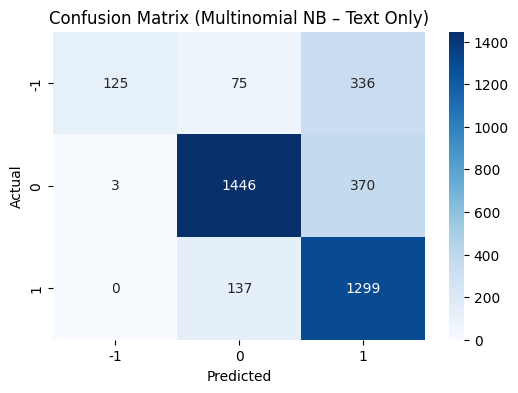


Saved predictions to: output_nb.csv


In [ ]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Load
file_path = "interstellar_posts_labelled.csv"
df = pd.read_csv(file_path)

# 2. Specify columns
TEXT_COL   = "TEXT"
SENT_SCORE = "sentiment"        # for CSV output only
LABEL_COL  = "sentiment_label"  # values are -1, 0, 1

# 3. Drop missing & preprocess
df.dropna(subset=[TEXT_COL, LABEL_COL], inplace=True)

def preprocess_text(t):
    t = t.lower()
    t = re.sub(r'\d+', '', t)
    t = t.translate(str.maketrans("", "", string.punctuation))
    return t.strip()

df[TEXT_COL] = df[TEXT_COL].astype(str).apply(preprocess_text)

# 4. Train/test split (30%)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    df[TEXT_COL],
    df[LABEL_COL],
    df[SENT_SCORE],
    test_size=0.3,
    random_state=42,
    stratify=df[LABEL_COL]
)

# 5. TF-IDF (text-only features)
vectorizer  = TfidfVectorizer(max_features=5000)
Xtr_tfidf   = vectorizer.fit_transform(X_train)
Xte_tfidf   = vectorizer.transform(X_test)

# 6. Train Multinomial NB
nb = MultinomialNB()
nb.fit(Xtr_tfidf, y_train)

# 7. Compute accuracies
train_acc = nb.score(Xtr_tfidf, y_train)
test_acc  = nb.score(Xte_tfidf, y_test)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")

# 8. Predict & detailed evaluation
y_pred = nb.predict(Xte_tfidf)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, labels=[-1,0,1]))

cm = confusion_matrix(y_test, y_pred, labels=[-1,0,1])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Multinomial NB – Text Only)")
plt.show()

# 9. Save predictions (including raw sentiment for reference)
results = pd.DataFrame({
    TEXT_COL:         X_test.values,
    SENT_SCORE:       s_test.values,
    "actual_label":   y_test.values,
    "predicted_label": y_pred
})
out_path = "output_nb.csv"
results.to_csv(out_path, index=False)
print(f"\nSaved predictions to: {out_path}")


In [ ]:
df = pd.read_csv("output_nb.csv")
print(df.head(20))

                                                 TEXT  sentiment  \
0   nolan’s next the odyssey\n\nlooks like at leas...     0.8415   
1   this is my flippus cuppus harmonius featuring ...     0.7163   
2                       hybrid factions   update news     0.0000   
3   how can i force trade factions to build statio...    -0.7686   
4   interstellar blend™ jing force kidney restorat...     0.0000   
5   best way to report bugs\n\nis there any stream...     0.9452   
6                        my recent euclid discoveries     0.0000   
7   cargo volume setting\n\nhello im thinking abou...     0.7937   
8   i took a dying leaf off my houseplant and pain...     0.0000   
9   forgotten photoshop and a tiny bit of illustra...    -0.4767   
10  generator k visual bug  version \n\ngreetings ...     0.8850   
11  they arent beings    they are us anyone else g...     0.0000   
12                       my recent euclid discoveries     0.0000   
13  help needed in preping non nerdy friend for 

In [ ]:
# Save the model and vectorizer
with open("naive_bayes_model.pkl", "wb") as model_file:
    pickle.dump(nb, model_file)
with open("nb_tfidf_vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

## LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 100)  │  1,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 32)        │     17,024 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8)         │         16 │ sentiment_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 8)         │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 40)        │          0 │ dropout_9[0][0],  │
│ (Concatenate)       │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │        656 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 16)        │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 3)         │         51 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,017,747 (3.88 MB)

 Trainable params: 1,017,747 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
97/97 - 38s - 392ms/step - accuracy: 0.5776 - loss: 0.9645 - val_accuracy: 0.8342 - val_loss: 0.7864
Epoch 2/20
97/97 - 29s - 297ms/step - accuracy: 0.7215 - loss: 0.7673 - val_accuracy: 0.8591 - val_loss: 0.5803
Epoch 3/20
97/97 - 32s - 334ms/step - accuracy: 0.7978 - loss: 0.5951 - val_accuracy: 0.8971 - val_loss: 0.3915
Epoch 4/20
97/97 - 44s - 450ms/step - accuracy: 0.8519 - loss: 0.4738 - val_accuracy: 0.9439 - val_loss: 0.2788
Epoch 5/20
97/97 - 35s - 359ms/step - accuracy: 0.8987 - loss: 0.3813 - val_accuracy: 0.9680 - val_loss: 0.2040
Epoch 6/20
97/97 - 42s - 435ms/step - accuracy: 0.9238 - loss: 0.3102 - val_accuracy: 0.9751 - val_loss: 0.1559
Epoch 7/20
97/97 - 39s - 404ms/step - accuracy: 0.9320 - loss: 0.2795 - val_accuracy: 0.9789 - val_loss: 0.1261
Epoch 8/20
97/97 - 32s - 325ms/step - accuracy: 0.9441 - loss: 0.2344 - val_accuracy: 0.9804 - val_loss: 0.1035
Epoch 9/20
97/97 - 38s - 394ms/step - accuracy: 0.9459 - loss: 0.2137 - val_accuracy: 0.9778 - val_loss:

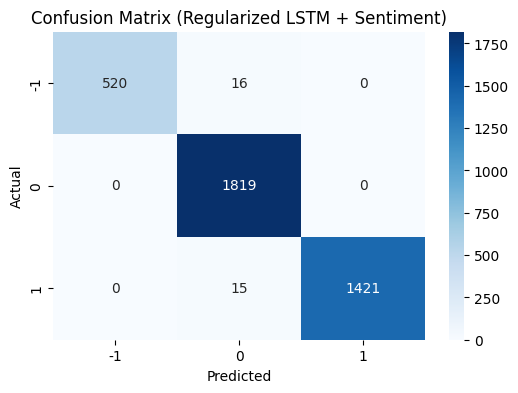


Saved predictions to: output_lstm_reg.csv


In [ ]:
import pandas as pd
import re
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, concatenate
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# 1. Load & clean
df = pd.read_csv("interstellar_posts_labelled.csv")
df.dropna(subset=["TEXT","sentiment_label","sentiment"], inplace=True)

def clean_text(t):
    t = t.lower()
    t = re.sub(r'\d+', '', t)
    t = t.translate(str.maketrans("","",string.punctuation))
    return t.strip()

df["TEXT"] = df["TEXT"].apply(clean_text)

# 2. Encode labels
label_map = {-1:0, 0:1, 1:2}
inv_map   = {v:k for k,v in label_map.items()}
df["label_enc"] = df["sentiment_label"].map(label_map)

# 3. Train/test split (30% test)
X_text = df["TEXT"].values
X_sent = df["sentiment"].values.reshape(-1,1)
y_enc  = df["label_enc"].values

Xtr_text, Xte_text, Xtr_sent, Xte_sent, y_tr, y_te = train_test_split(
    X_text, X_sent, y_enc,
    test_size=0.3, random_state=42, stratify=y_enc
)

# 4. Tokenize & pad
max_words = 10000
max_len   = 100
tok       = Tokenizer(num_words=max_words, oov_token="<UNK>")
tok.fit_on_texts(Xtr_text)

seq_tr = tok.texts_to_sequences(Xtr_text)
seq_te = tok.texts_to_sequences(Xte_text)

Xtr_pad = pad_sequences(seq_tr, maxlen=max_len, padding='post', truncating='post')
Xte_pad = pad_sequences(seq_te, maxlen=max_len, padding='post', truncating='post')

# 5. One-hot labels
ytr_cat = to_categorical(y_tr, num_classes=3)
yte_cat = to_categorical(y_te, num_classes=3)

# 6. Build regularized two-input model
embedding_dim = 100

# Text branch
text_in = Input(shape=(max_len,), name="text_input")
x = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)(text_in)
x = LSTM(32, recurrent_dropout=0.3)(x)
x = Dropout(0.5)(x)

# Sentiment branch
sent_in = Input(shape=(1,), name="sentiment_input")
s = Dense(8, activation="relu", kernel_regularizer=l2(1e-4))(sent_in)
s = Dropout(0.3)(s)

# Merge
merged = concatenate([x, s])
m = Dense(16, activation="relu", kernel_regularizer=l2(1e-4))(merged)
m = Dropout(0.5)(m)
out = Dense(3, activation="softmax")(m)

model = Model(inputs=[text_in, sent_in], outputs=out)
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# 7. Callbacks
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

model.build(input_shape=[(None, max_len),(None,1)])
model.summary()

# 8. Train with validation split
history = model.fit(
    {"text_input": Xtr_pad, "sentiment_input": Xtr_sent},
    ytr_cat,
    epochs=20,
    batch_size=64,
    validation_split=0.3,
    callbacks=[early_stop],
    verbose=2
)

# 9. Evaluate
train_loss, train_acc = model.evaluate(
    {"text_input": Xtr_pad, "sentiment_input": Xtr_sent}, ytr_cat, verbose=0
)
test_loss, test_acc   = model.evaluate(
    {"text_input": Xte_pad, "sentiment_input": Xte_sent}, yte_cat, verbose=0
)
print(f"\nTrain Acc: {train_acc:.4f}    Test Acc: {test_acc:.4f}")

# 10. Predict & metrics
y_probs    = model.predict({"text_input": Xte_pad, "sentiment_input": Xte_sent})
y_pred_enc = np.argmax(y_probs, axis=1)
y_pred     = [inv_map[i] for i in y_pred_enc]
y_true     = [inv_map[i] for i in y_te]

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, labels=[-1,0,1]))

cm = confusion_matrix(y_true, y_pred, labels=[-1,0,1])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Regularized LSTM + Sentiment)")
plt.show()

# 11. Save predictions
out = pd.DataFrame({
    "TEXT":            Xte_text,
    "sentiment":       Xte_sent.flatten(),
    "actual_label":    y_true,
    "predicted_label": y_pred
})
out.to_csv("output_lstm_reg.csv", index=False)
print("\nSaved predictions to: output_lstm_reg.csv")


In [ ]:
df = pd.read_csv("output_lstm.csv")
print(df.head(20))

                                                 TEXT  sentiment  \
0   nolan’s next the odyssey\n\nlooks like at leas...     0.8415   
1   this is my flippus cuppus harmonius featuring ...     0.7163   
2                       hybrid factions   update news     0.0000   
3   how can i force trade factions to build statio...    -0.7686   
4   interstellar blend™ jing force kidney restorat...     0.0000   
5   best way to report bugs\n\nis there any stream...     0.9452   
6                        my recent euclid discoveries     0.0000   
7   cargo volume setting\n\nhello im thinking abou...     0.7937   
8   i took a dying leaf off my houseplant and pain...     0.0000   
9   forgotten photoshop and a tiny bit of illustra...    -0.4767   
10  generator k visual bug  version \n\ngreetings ...     0.8850   
11  they arent beings    they are us anyone else g...     0.0000   
12                       my recent euclid discoveries     0.0000   
13  help needed in preping non nerdy friend for 

In [ ]:
import pickle
from sklearn.preprocessing import LabelEncoder

# --- After you’ve trained your model ---

# 1. Save the Keras LSTM model to H5
model.save("lstm_model.h5")
print("Saved LSTM model to lstm_model.h5")

# 2. Persist the Tokenizer
with open("tokenizer.pkl", "wb") as f_tok:
    pickle.dump(tok, f_tok) # Changed to tok, as tokenizer was not defined
print("Saved Tokenizer to tokenizer.pkl")

# 3. Build & fit a LabelEncoder on your original labels (-1,0,1)
#    (this must match the mapping you used at train time)
le = LabelEncoder()
# use 'actual_label' instead of LABEL_COL
le.fit(df['actual_label'].astype(str))   # ensure strings if you mixed ints
with open("label_encoder.pkl", "wb") as f_le:
    pickle.dump(le, f_le)
print("Saved LabelEncoder to label_encoder.pkl")

Saved LSTM model to lstm_model.h5
Saved Tokenizer to tokenizer.pkl
Saved LabelEncoder to label_encoder.pkl


## TRANSFORMER

Classes: ['-1' '0' '1']


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer                 │ (None, 150, 64)        │       649,600 │
│ (EmbeddingLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer (EncoderLayer)    │ (None, 150, 64)        │        41,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 695,619 (2.65 MB)

 Trainable params: 695,619 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
316/316 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6607 - loss: 0.8206 - val_accuracy: 0.7951 - val_loss: 0.4628
Epoch 2/5
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9007 - loss: 0.2779 - val_accuracy: 0.9513 - val_loss: 0.1580
Epoch 3/5
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9801 - loss: 0.0644 - val_accuracy: 0.9581 - val_loss: 0.1474
Epoch 4/5
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9922 - loss: 0.0260 - val_accuracy: 0.9664 - val_loss: 0.1790
Epoch 5/5
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9959 - loss: 0.0138 - val_accuracy: 0.9739 - val_loss: 0.1589


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9716 - loss: 0.1681
Validation Accuracy: 0.9739


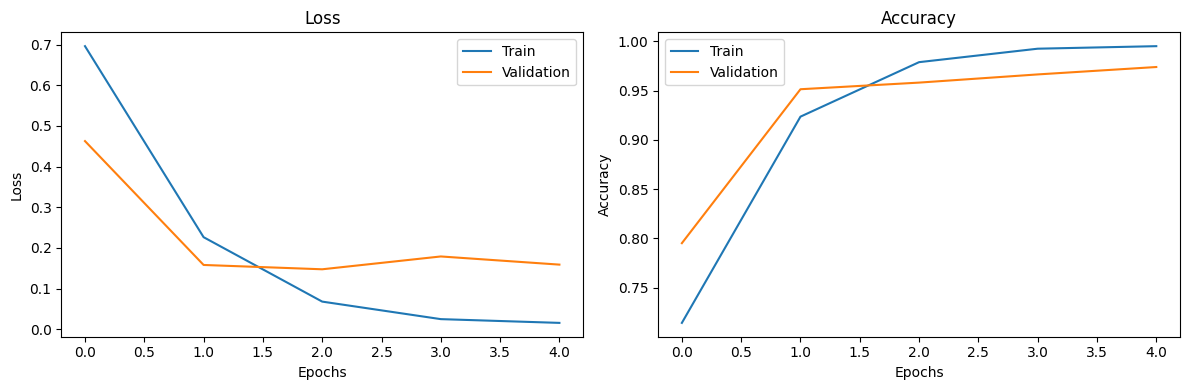

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


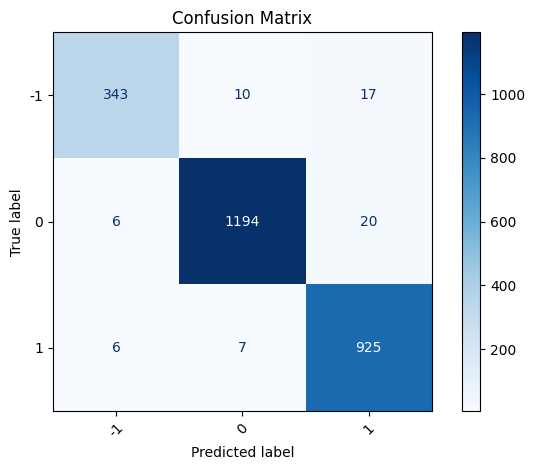

In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense, Input, LayerNormalization, MultiHeadAttention, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

# Load dataset
data = pd.read_csv('interstellar_posts_labelled.csv')

# Drop rows with missing TEXT
data = data.dropna(subset=['TEXT'])

# Extract features and labels
texts = data['TEXT'].astype(str).values
labels = data['sentiment_label'].astype(str).values  # Convert to string for encoding

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Save LabelEncoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Get class names
class_names = label_encoder.classes_
print("Classes:", class_names)

# Define vectorization parameters
vocab_size = 10000
sequence_length = 150

# Vectorization layer
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=sequence_length
)

# Adapt vectorizer to texts
text_ds = tf.data.Dataset.from_tensor_slices(texts).batch(32)
vectorize_layer.adapt(text_ds)

# Save the vectorizer
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorize_layer, f)

# Vectorize text data
texts_vectorized = vectorize_layer(texts).numpy()

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    texts_vectorized, categorical_labels, test_size=0.2, random_state=42
)

# Custom Embedding Layer
class EmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super(EmbeddingLayer, self).__init__()
        self.word_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embedding = Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, tokens):
        positions = tf.range(start=0, limit=tf.shape(tokens)[-1], delta=1)
        return self.word_embedding(tokens) + self.position_embedding(positions)

# Transformer Encoder Layer
class EncoderLayer(Layer):
    def __init__(self, total_heads, total_dense_units, embed_dim):
        super(EncoderLayer, self).__init__()
        self.multihead = MultiHeadAttention(num_heads=total_heads, key_dim=embed_dim)
        self.nnw = Sequential([
            Dense(total_dense_units, activation="relu"),
            Dense(embed_dim)
        ])
        self.norm = LayerNormalization()

    def call(self, inputs):
        attn_output = self.multihead(inputs, inputs)
        x = self.norm(inputs + attn_output)
        nnw_output = self.nnw(x)
        return self.norm(x + nnw_output)

# Model parameters
embed_dim = 64
num_heads = 2
dense_units = 64

# Build the model
inputs = Input(shape=(sequence_length,))
x = EmbeddingLayer(sequence_length, vocab_size, embed_dim)(inputs)
x = EncoderLayer(num_heads, dense_units, embed_dim)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(dense_units, activation="relu")(x)
outputs = Dense(len(class_names), activation="softmax")(x)

transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
transformer_model.summary()

# Train the model
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=5,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
)

# Save the model
transformer_model.save("transformer_sentiment_model.h5")

# Evaluate on validation set
val_metrics = transformer_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_metrics[1]:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
for i, metric in enumerate(['loss', 'accuracy']):
    plt.subplot(1, 2, i+1)
    plt.plot(history.history[metric], label='Train')
    plt.plot(history.history[f'val_{metric}'], label='Validation')
    plt.title(metric.title())
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix
y_pred = np.argmax(transformer_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# Generate predictions on the full dataset (or validation set)
texts_vectorized_all = vectorize_layer(texts).numpy()
pred_probs = transformer_model.predict(texts_vectorized_all)
pred_classes = np.argmax(pred_probs, axis=1)
pred_labels = label_encoder.inverse_transform(pred_classes)

# Add predictions and confidence scores to the original DataFrame
data['predicted_label'] = pred_labels
data['confidence_score'] = np.max(pred_probs, axis=1)

# Save the DataFrame with predictions to a new CSV
output_path = 'output_transformer.csv'
data.to_csv(output_path, index=False)

print(f"Predictions saved to: {output_path}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predictions saved to: output_transformer.csv


In [ ]:
df = pd.read_csv("output_transformer.csv")
print(df.head(20))

    SNO SUBREDDIT_NAME                                               TEXT  \
0     1   interstellar  Monthly Interstellar Showings Megathread\n\nht...   
1     2   interstellar  New Rule: No Photos or Videos from Theatrical ...   
2     3   interstellar  Look what we have here\n\n*docking scene*\n\nB...   
3     4   interstellar  when they stop the spin to observe the wormhol...   
4     5   interstellar  COME ON, TARS\n\nI don't know if this was a de...   
5     6   interstellar                  Trans dimensional War Thunder\n\n   
6     7   interstellar  Original Piano Sheet music\n\nHelp me find the...   
7     8   interstellar                    Endurance from Interstellar\n\n   
8     9   interstellar  Feeling like the dust bowl in Western Kansas [...   
9    10   interstellar  YouTube just made my day\n\nhttps://preview.re...   
10   11   interstellar  Hans Zimmer - Interstellar (Royal Albert Hall ...   
11   12   interstellar       Yesterday's sandstorm in Saudi Arabia 🇸🇦\n\n   

# ENSEMBLE MODEL

In [ ]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.layers import Layer, MultiHeadAttention, Dense, Embedding, LayerNormalization
from tensorflow.keras.models import Sequential

# Load saved models and vectorizers
with open('svm_model.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('svm_tfidf_vectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('xgb_tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('lstm_label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('lstm_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('naive_bayes_model.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('nb_tfidf_vectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

with open('transformer_label_encoder.pkl', 'rb') as file:
    t_label_encoder = pickle.load(file)

with open('transformer_vectorizer.pkl', 'rb') as file:
    t_vectorize_layer = pickle.load(file)

# Define custom Transformer layers
class EmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(EmbeddingLayer, self).__init__(**kwargs)
        self.word_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embedding = Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, tokens):
        positions = tf.range(start=0, limit=tf.shape(tokens)[-1], delta=1)
        return self.word_embedding(tokens) + self.position_embedding(positions)

class EncoderLayer(Layer):
    def __init__(self, total_heads, total_dense_units, embed_dim, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.multihead = MultiHeadAttention(num_heads=total_heads, key_dim=embed_dim)
        self.nnw = Sequential([
            Dense(total_dense_units, activation="relu"),
            Dense(embed_dim)
        ])
        self.norm = LayerNormalization()

    def call(self, inputs):
        attn_output = self.multihead(inputs, inputs)
        x = self.norm(inputs + attn_output)
        nnw_output = self.nnw(x)
        return self.norm(x + nnw_output)

# Load transformer model
custom_objects = {
    "EmbeddingLayer": EmbeddingLayer,
    "EncoderLayer": EncoderLayer
}
transformer_model = load_model('transformer_model.h5', custom_objects=custom_objects)

# Load dataset
data = pd.read_csv('interstellar_posts_labelled.csv')
data.dropna(subset=['TEXT'], inplace=True)

X_test = data['TEXT']
y_test = data['sentiment_label']
label_encoder = t_label_encoder
label_encoder.fit(data['sentiment_label'])
y_test = label_encoder.transform(data['sentiment_label'])

# Preprocessing
X_test_svm = svm_vectorizer.transform(X_test)
X_test_nb = nb_vectorizer.transform(X_test)
X_test_xgb = tfidf_vectorizer.transform(X_test)

X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

X_test_transformer = t_vectorize_layer(X_test)

# Model predictions
svm_predictions = svm_model.predict(X_test_svm)
svm_predictions_proba = to_categorical(svm_predictions, num_classes=3)

nb_predictions_proba = nb_model.predict_proba(X_test_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)

X_test_sent = data['sentiment'].values.reshape(-1, 1)
lstm_predictions_proba = lstm_model.predict({'text_input': X_test_lstm, 'sentiment_input': X_test_sent})
transformer_predictions_proba = transformer_model.predict(X_test_transformer)

# Stack features
stacked_features = np.hstack((
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba,
    transformer_predictions_proba
))

# Encode labels
y_full = label_encoder.transform(data['sentiment_label'].astype(str))

# Shuffle before splitting
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    stacked_features, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Updated Random Forest meta-learner with regularization
meta_learner_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)
meta_learner_rf.fit(X_train1, y_train1)

# Save trained model
with open('meta_learner_rf.pkl', 'wb') as file:
    pickle.dump(meta_learner_rf, file)

# Evaluation
final_predictions_rf = meta_learner_rf.predict(X_test1)
accuracy_rf = accuracy_score(y_test1, final_predictions_rf)

target_names = [str(cls) for cls in label_encoder.classes_]
report_rf = classification_report(y_test1, final_predictions_rf, target_names=target_names)

print(f"\nRandom Forest Meta-Learner Accuracy: {accuracy_rf * 100:.2f}%")
print("Classification Report:\n", report_rf)
print("Confusion Matrix:\n", confusion_matrix(y_test1, final_predictions_rf))

# 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_accuracies = cross_val_score(meta_learner_rf, stacked_features, y_full, cv=cv, scoring='accuracy')
mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

print(f"\nCross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")

# Output to CSV
final_preds_all = meta_learner_rf.predict(stacked_features)
pred_labels_all = label_encoder.inverse_transform(final_preds_all)
confidences = meta_learner_rf.predict_proba(stacked_features).max(axis=1)

data['predicted_label'] = pred_labels_all
data['confidence_score'] = confidences
output_path = 'output_ensemble.csv'
data.to_csv(output_path, index=False)

print(f"\nPredictions saved to: {output_path}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Random Forest Meta-Learner Accuracy: 99.96%
Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00       358
           0       1.00      1.00      1.00      1213
           1       1.00      1.00      1.00       957

    accuracy                           1.00      2528
   macro avg       1.00      1.00      1.00      2528
weighted avg       1.00      1.00      1.00      2528

Confusion Matrix:
 [[ 357    1    0]
 [   0 1213    0]
 [   0    0  957]]

Cross-Validation Accuracies: [1. 1. 1. 1. 1.]
Mean Validation Accuracy: 100.00%
Validation Accuracy Std Dev: 0.00%

Predictions saved to: output_ensemble.csv


In [ ]:
df = pd.read_csv("output_ensemble.csv")
print(df.head(20))

    SNO SUBREDDIT_NAME                                               TEXT  \
0     1   interstellar  Monthly Interstellar Showings Megathread\n\nht...   
1     2   interstellar  New Rule: No Photos or Videos from Theatrical ...   
2     3   interstellar  Look what we have here\n\n*docking scene*\n\nB...   
3     4   interstellar  when they stop the spin to observe the wormhol...   
4     5   interstellar  COME ON, TARS\n\nI don't know if this was a de...   
5     6   interstellar                  Trans dimensional War Thunder\n\n   
6     7   interstellar  Original Piano Sheet music\n\nHelp me find the...   
7     8   interstellar                    Endurance from Interstellar\n\n   
8     9   interstellar  Feeling like the dust bowl in Western Kansas [...   
9    10   interstellar  YouTube just made my day\n\nhttps://preview.re...   
10   11   interstellar  Hans Zimmer - Interstellar (Royal Albert Hall ...   
11   12   interstellar       Yesterday's sandstorm in Saudi Arabia 🇸🇦\n\n   

# RoBERTa accuracy on the VADER labelled dataset

In [1]:
import pandas as pd

# Load the dataframe.
df = pd.read_csv("interstellar_posts_labelled.csv")

# Extract the 'sentiment_label' column.
sentiment_labels = df['sentiment_label']

# Convert the sentiment labels to integers and store them in a list.
int_labels = [int(label) for label in sentiment_labels]

# Display the list of integer labels.
print("Integer Labels:", int_labels)

# Calculate the total count of labels.
total_count = len(int_labels)
print("Total Count:", total_count)

# Calculate the count of each unique label.
count_1 = int_labels.count(1)
count_0 = int_labels.count(0)
count_neg_1 = int_labels.count(-1)

print("Count of 1:", count_1)
print("Count of 0:", count_0)
print("Count of -1:", count_neg_1)

vader = int_labels

Integer Labels: [1, 1, 0, -1, 1, -1, 1, 0, 1, 0, 0, 0, -1, -1, -1, 0, 1, 1, 0, -1, 1, 1, 1, -1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, -1, 1, 0, 0, -1, 0, 0, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 0, 0, 1, 1, -1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, -1, 1, -1, 0, -1, 0, 1, 1, -1, 0, 0, 0, 1, 0, 1, 1, 0, -1, 1, 0, 0, -1, 0, -1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, -1, 1, -1, 0, 1, 0, 1, -1, 0, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 0, 1, 0, 1, -1, 1, 0, 0, 0, -1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 0, -1, -1, 1, 0, 1, 0, 1, 1, 1, -1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, -1, -1, 1, 1, -1, 0, 1, 1, 1, 0, 0, 1, -1, 1, -1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, -1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, -1, 0, 1, 1, -1, 0, -1, 1, 1, 1, 1, 1, 1, 1, 1, 0, -1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 

In [2]:

import pandas as pd

# Load the dataframe.
df = pd.read_csv("output_roberta.csv")

# Extract the 'sentiment' column.
sentiment_column = df['sentiment']

# Mapping function
def map_sentiment(sentiment):
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return -1
    elif sentiment == 'neutral':
        return 0
    else:
        return 1

# Map sentiment labels to integers
int_labels = [map_sentiment(sentiment) for sentiment in sentiment_column]

# Display the list of integer labels
print("Integer Labels:", int_labels)

# Calculate counts
total_count = len(int_labels)
count_1 = int_labels.count(1)
count_0 = int_labels.count(0)
count_neg_1 = int_labels.count(-1)

print("\nCounts:")
print("Total Count:", total_count)
print("Count of 1:", count_1)
print("Count of 0:", count_0)
print("Count of -1:", count_neg_1)

roberta = int_labels

Integer Labels: [0, -1, 0, -1, 1, 0, 0, 0, -1, 0, 0, -1, -1, -1, -1, 0, -1, 1, 0, -1, -1, 0, -1, -1, -1, 1, -1, 1, 0, 0, 0, 1, 1, 1, -1, -1, 1, 0, 1, 0, 1, 1, -1, -1, 1, 0, -1, 1, 0, 0, 1, -1, -1, 0, 0, -1, 0, 0, 1, -1, -1, 1, 0, 0, -1, -1, 1, -1, -1, -1, 0, 1, 0, 0, 0, -1, 0, -1, -1, 0, 0, 1, -1, -1, 1, 0, 0, 0, -1, 1, 0, 1, 1, -1, 0, 1, -1, -1, 1, -1, 0, -1, 0, 0, -1, -1, 0, 0, 0, 0, -1, 1, 0, 0, -1, -1, 0, -1, -1, 0, -1, 0, 1, 1, -1, 0, 1, 1, -1, 0, 1, 0, -1, 0, -1, 1, -1, -1, 0, -1, 0, 0, 1, 0, 1, 0, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, -1, 1, 0, -1, 0, 0, 0, 1, 0, 0, 1, 0, -1, 0, 0, -1, 0, -1, 1, 0, 0, 1, 0, 0, 0, -1, 0, 1, 0, 1, 0, -1, 1, 1, 1, -1, 1, 1, 1, 0, -1, -1, -1, -1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, 1, 1, 1, 1, 0, -1, -1, 0, -1, -1, 1, 0, 1, 1, 0, -1, -1, -1, 1, -1, -1, 0, 0, 1, 0, 1, 0, -1, 1, -1, 0, -1, 0, -1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, -1, -1, 0, 1, 0, 0, 1, 0, 1, -1, 1, 1, 0, 0, 1, -1, 0, 0, 0, 0, -1, 0, 0, -1, 0, -1, 1, -1, 1, 1, 0, 0, 0, 1, 0, -1, 0, -1,

In [3]:
def compare_lists(vader, roberta):
    """
    Compares two lists and returns the percentage of matching values.

    Args:
        vader: The first list.
        roberta: The second list.

    Returns:
        The percentage of values in roberta that match the corresponding values in vader.
        Returns 0 if the lists are of different lengths or empty.
    """
    if len(vader) != len(roberta) or not vader or not roberta:
        return 0

    matches = sum(1 for v, r in zip(vader, roberta) if v == r)
    return (matches / len(vader)) * 100


# Slice the last 30% of both lists
start_index = int(len(vader) * 0.7)
vader_last_30 = vader[start_index:]
roberta_last_30 = roberta[start_index:]

# Compare only the last 30%
percentage_match = compare_lists(vader_last_30, roberta_last_30)
print(f"Percentage of matching values (last 30%): {percentage_match:.2f}%")


Percentage of matching values (last 30%): 74.78%
